# Micrograd

Neste notebook, vamos criar um sistema de diferenciação automático e aplicá-lo para resolver redes neurais. Em alguma medida, o código abaixo replica o funcionamento de bibliotecas importantes em deep learning, como PyTorch e Tensorflow.

Esse notebook é baseado no repositório do "micrograd", do Andrej Karpathy. Para mais detalhes, veja o repositório https://github.com/karpathy/micrograd/ e o vídeo https://www.youtube.com/watch?v=VMj-3S1tku0.

In [1]:
# !conda install -c anaconda python-graphviz
# !conda install -c anaconda pydot

In [2]:
import random
from graphviz import Digraph
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Introdução: diferenciação automática

A base da otimização de redes neurais é descida de gradiente, que por sua vez depende da capacidade de encontrar derivadas automaticamente. Em primeiro lugar, é útil entender quão simples tomar uma derivada pode ser, do ponto de vista computacional.

In [3]:
# Derivada simples
def f(x):
    return 3*(x**2) - 4*x + 5

h = 0.0000000001
x = 3

# Derivada: 6*x-4; em x=3, isso é 18-4=14
(f(x+h)-f(x))/h

14.000001158365194

In [4]:
# Derivada parcial
def f(a, b, c, d):
    return (a*b+c)*d

h = 0.0000000001
a = 2
b = -3
c = 10
d = -2

print(f" Derivada em a: {(f(a+h, b, c, d)-f(a, b, c, d))/h}")
print(f" Derivada em b: {(f(a, b+h, c, d)-f(a, b, c, d))/h}")
print(f" Derivada em c: {(f(a, b, c+h, d)-f(a, b, c, d))/h}")
print(f" Derivada em d: {(f(a, b, c, d+h)-f(a, b, c, d))/h}")

 Derivada em a: 6.000000496442226
 Derivada em b: -4.000000330961484
 Derivada em c: -2.000000165480742
 Derivada em d: 4.000000330961484


Apesar de encontrarmos a derivada corretamente acima, ela não é conveniente por dois motivos: (i) ela introduz erros de aproximação e (ii) ela envolve mais computação do que o necessário.

Em termos de (i), mesmo que os erros pareçam pequenos, eles podem acabar se acumulando a ponto de se tornarem totalmente não-triviais. Já (ii) significa que existe uma maneira mais simples de encontrar a derivada, que é automatizando as fórmulas das derivadas analiticamente.

O objetivo a partir daqui é obter um jeito simples de tomar derivadas automaticamente, mesmo que elas sejam muito complexas. %A ideia vai ser utilizar a regra da cadeia para quebrar uma derivada potencialmente complicada numa sequência de derivadas muitos simples.

## Primeiro passo: classes

Nossa ideia fundamental é quebrar a derivada de expressões muito complexas numa sequência de derivadas muito simples. Para isso, vai ser muito útil a gente associar a cada operação matemática uma expressão para a sua derivada. Em Python, uma maneira de associar operações e derivadas é através de classes. 

Uma classe é uma estrutura de dados que permite encapsular operações e objetos dentro. Vamos começar criando uma classe muito simples, que guarda apenas o valor de cada ponto e associa a ele uma etiqueta. Com isso, por exemplo, seremos capazes de criar um grafo de operações.

Em Python, uma classe sempre recebe uma função inicializadora `__init__()`, que instancia a classe como um objeto. Além disso, a classe possui um conjunto de funções que indicam as operações que podem incidir sobre o objeto.

In [5]:
class Value:

    def __init__(self, data, label=''):
        self.data = data
        self.label = label

In [6]:
a = Value(3, 'a')

In [7]:
a.data

3

In [8]:
a.label

'a'

In [9]:
print(a)

Como não definimos o que Python deveria fazer quando rodamos `print(a)`, isto é, de que maneira Python deveria representar um Value, ele retorna algo que não nos é tão útil. Podemos mudar isso definindo uma função especial na classe, `__repr__()`, que explica o que deve ser impresso.

In [10]:
class Value:

    def __init__(self, data, label=''):
        self.data = data
        self.label = label
        
    def __repr__(self):
        return f"Value(data={self.data}, label={self.label})"

In [11]:
a = Value(3, 'a')
print(a)

Value(data=3, label=a)


Ótimo. Se Python precisou que explicássemos como representar um Value, será que ele sabe como somá-los?

In [12]:
a = Value(3, 'a')
b = Value(4, 'b')

In [13]:
a + b

TypeError: unsupported operand type(s) for +: 'Value' and 'Value'

Nós podemos remediar essa situação definindo dentro da classe como isso deve ocorrer. Nesse caso, usamos a função `__add__()`, que é o que Python chama internamente quando invocamos `+`. Note que várias dessas funções têm um duplo sublinhado; isso significa que é uma função com sentido especial para Python (no caso, a operação `+`).

In [14]:
class Value:

    def __init__(self, data, label=''):
        self.data = data
        self.label = label
        
    def __add__(self, other):
        out = Value(self.data + other.data, label=f'{self.label}+{other.label}')
        return out
    
    def __repr__(self):
        return f"Value(data={self.data}, label={self.label})"

In [15]:
a = Value(3, 'a')
b = Value(4, 'b')
a + b

Value(data=7, label=a+b)

No futuro, vai ser útil converter números para Value automaticamente, de modo que possamos fazer `a+3` e dar tudo certo. Para isso, vamos incluir uma conversão automática no código da soma, 

In [16]:
class Value:

    def __init__(self, data, label=''):
        self.data = data
        self.label = label
        
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, label=f'{self.label}+{other.label}')
        return out
    
    def __repr__(self):
        return f"Value(data={self.data}, label={self.label})"

In [17]:
a = Value(3, 'a')
b = 4
a + b

Value(data=7, label=a+)

In [18]:
b + a

TypeError: unsupported operand type(s) for +: 'int' and 'Value'

O problema acima vem do fato de que `a + b` vira `a.__add__(b)`, o que é bem-definido. Mas `b+a` vira `b.__add__(a)` e o método `__add__()` implementado para ints em Python não sabe o que é essa classe nova que definimos. Uma maneira de resolver o problema é usar outra função especial dentro de uma classe chamada `__radd__()` (para "right add"): se `b.__add__(a)` falha, antes de lançar o erro Python roda `a.__radd__(b)`.

In [19]:
class Value:

    def __init__(self, data, label=''):
        self.data = data
        self.label = label
        
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, label=f'{self.label}+{other.label}')
        return out

    def __radd__(self, other):
        return self + other
    
    def __repr__(self):
        return f"Value(data={self.data}, label={self.label})"

In [20]:
a = Value(3, 'a')
b = 4
a + b

Value(data=7, label=a+)

In [21]:
b + a

Value(data=7, label=a+)

Agora que a soma funciona do jeito que gostaríamos, vamos adicionar outras operações importantes para otimizar uma rede neural, como * (`__mul__`), ** (`__pow__`), - (`__sub__`), / (`__truediv__`), além das contrapartidas à direita e funções de ativação, como ReLU.

In [22]:
class Value:

    def __init__(self, data, label=''):
        self.data = data
        self.label = label

    def __add__(self, other): # self + other
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, '+')
        return out

    def __mul__(self, other): # self * other
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, '*')
        return out

    def __pow__(self, other): # self ** other
        assert isinstance(other, (int, float)), "Only supporting int/float powers for now"
        out = Value(self.data**other, f'**{other}')
        return out

    def relu(self):
        out = Value(0 if self.data < 0 else self.data, 'ReLU')
        return out

    def __neg__(self): # -self
        return self * -1

    def __radd__(self, other): # other + self
        return self + other

    def __sub__(self, other): # self - other
        return self + (-other)

    def __rsub__(self, other): # other - self
        return other + (-self)

    def __rmul__(self, other): # other * self
        return self * other

    def __truediv__(self, other): # self / other
        return self * other**-1

    def __rtruediv__(self, other): # other / self
        return other * self**-1

    def __repr__(self):
        return f"Value(data={self.data}, label={self.label})"

In [23]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a * b; e.label='e'
d = e + c; d.label='d'
g = Value(-2, label='g')
L = d * g; L.label='L'
L

Value(data=-8.0, label=L)

Até agora, extraímos poucas vantagens de todo o nosso trabalho. Mas isso vai começar a mudar. Uma coisa que podemos fazer com essa classe é guardar toda a sequência de operações usadas para encontrar `L` acima, e com isso construir um grafo de operações.

A maneira de se fazer isso é guardar dentro de cada objeto Value quem foram os Values que o criaram e com qual operação. Para isso, vamos guardar na classe as informações `_children` e `_op`.

In [24]:
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "Only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')
        return out

    def relu(self):
        out = Value(0 if self.data < 0 else self.data, (self,), 'ReLU')
        return out

    def __neg__(self):
        return self * -1

    def __radd__(self, other):
        return self + other

    def __sub__(self, other):
        return self + (-other)

    def __rsub__(self, other):
        return other + (-self)

    def __rmul__(self, other):
        return self * other

    def __truediv__(self, other):
        return self * other**-1

    def __rtruediv__(self, other):
        return other * self**-1

    def __repr__(self):
        return f"Value(data={self.data}, label={self.label})"

In [25]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = a + b

In [26]:
c._prev

{Value(data=-3.0, label=b), Value(data=2.0, label=a)}

In [27]:
c._op

'+'

Finalmente, seria legal visualizar tudo isso. Para isso, vamos precisar de umas funções auxiliares cujo único objetivo é imprimir um grafo. Não é necessário entender em detalhes o que está acontecendo aqui; o resultado está logo abaixo.

In [28]:
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw(root, format='svg', rankdir='LR'):
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{%s | data %.4f }" % (n.label, n.data), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

Agora, podemos visualizar todas as operações feitas para chegar até um valor.

In [29]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a * b; e.label='e'
d = e + c; d.label='d'
g = Value(-2, label='g')
L = d * g; L.label='L'
L

Value(data=-8.0, label=L)

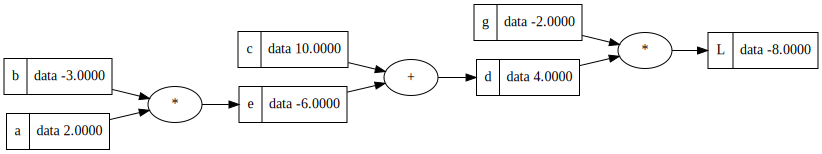

In [30]:
draw(L)

## Derivadas

Mesmo que consigamos criar grafos usando a nossa classe, nosso real interesse nessa construção é poder tirar derivadas automaticamente. Para isso, gostaríamos de associar a cada entrada do grafo acima o valor da derivada localmente.

Vamos considerar um exemplo.

In [31]:
a = Value(3, 'a')
b = Value(2, 'b')
c = a * b; c.label='c'

Quem é a derivada de `c` em `c`? Deve ser 1, naturalmente. E a derivada de `c` em `a`? Como `c = a*b`, a derivada deveria ter valor `b`.

In [32]:
h = 0.00001

def f(a, b):
    return (a*b).data

print(f"Derivada: {(f(a+h, b) - f(a, b))/h}")

Derivada: 2.0000000000131024


Podemos começar a introduzir a ideia de derivada na nossa classe notando que ela é algo muito simples para as funções que já definimos: a derivada de `a+b` em `a` é 1; a derivada de `a*b` em `a` é `b`. Vamos incluir isso na nossa classe inicializando um valor `self.grad=0` e atualizando esse valor quando uma operação `+` ou `*` acontecer.

In [33]:
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 1
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        
        self.grad = 1
        other.grad = 1
        
        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        
        self.grad = other.data
        other.grad = self.data
            
        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "Only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')
        return out

    def relu(self):
        out = Value(0 if self.data < 0 else self.data, (self,), 'ReLU')
        return out

    def __neg__(self):
        return self * -1

    def __radd__(self, other):
        return self + other

    def __sub__(self, other):
        return self + (-other)

    def __rsub__(self, other):
        return other + (-self)

    def __rmul__(self, other):
        return self * other

    def __truediv__(self, other):
        return self * other**-1

    def __rtruediv__(self, other):
        return other * self**-1

    def __repr__(self):
        return f"Value(data={self.data}, label={self.label})"

In [34]:
a = Value(3, 'a')
b = Value(2, 'b')
c = a * b

print(f"Derivada em a: {a.grad}")
print(f"Derivada em b: {b.grad}")
print(f"Derivada em c: {c.grad}")

Derivada em a: 2
Derivada em b: 3
Derivada em c: 1


In [35]:
a = Value(3, 'a')
b = Value(2, 'b')
c = a + b

print(f"Derivada em a: {a.grad}")
print(f"Derivada em b: {b.grad}")
print(f"Derivada em c: {c.grad}")

Derivada em a: 1
Derivada em b: 1
Derivada em c: 1


In [36]:
a = Value(3, 'a')
b = Value(2, 'b')
c = 2*a + b

print(f"Derivada em a: {a.grad}")
print(f"Derivada em b: {b.grad}")
print(f"Derivada em c: {c.grad}")

Derivada em a: 2
Derivada em b: 1
Derivada em c: 1


Vamos incluir as derivadas na nossas visualizações:

In [37]:
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw(root, format='svg', rankdir='LR'):
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{%s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

In [38]:
a = Value(3, label='a')
b = Value(2, label='b')
c = a*b; c.label='c'

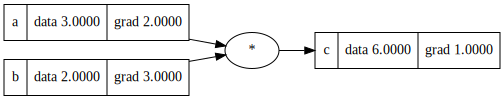

In [39]:
draw(c)

Mas agora esbarramos num problema. Calcular derivadas desse jeito só funciona nos casos mais simples, como o acima. Considere uma situação um pouco mais complicada:

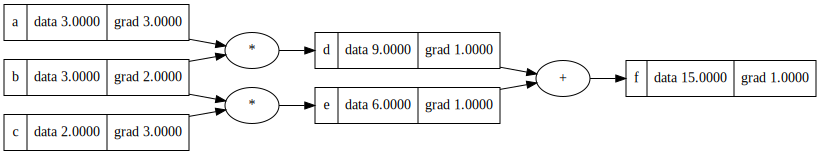

In [40]:
a = Value(3, label='a')
b = Value(3, label='b')
c = Value(2, label='c')

d = a*b; d.label='d'
e = b*c; e.label='e'

f = d+e; f.label='f'

draw(f)

Precisamos acumular as derivadas em `b` para que eles estejam corretos. Vamos fazer isso inicializando a derivada como 0, e somando toda vez que o objeto (nesse caso, `b`) participa de uma operação.

In [41]:
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        
        self.grad += 1
        other.grad += 1
        
        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        
        self.grad += other.data
        other.grad += self.data
            
        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "Only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')
        return out

    def relu(self):
        out = Value(0 if self.data < 0 else self.data, (self,), 'ReLU')
        return out

    def __neg__(self):
        return self * -1

    def __radd__(self, other):
        return self + other

    def __sub__(self, other):
        return self + (-other)

    def __rsub__(self, other):
        return other + (-self)

    def __rmul__(self, other):
        return self * other

    def __truediv__(self, other):
        return self * other**-1

    def __rtruediv__(self, other):
        return other * self**-1

    def __repr__(self):
        return f"Value(data={self.data}, label={self.label})"

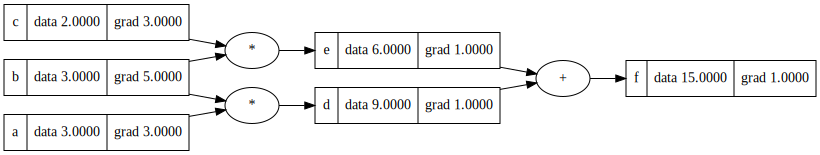

In [42]:
a = Value(3, label='a')
b = Value(3, label='b')
c = Value(2, label='c')

d = a*b; d.label='d'
e = b*c; e.label='e'

f = d+e; f.label='f'
f.grad = 1

draw(f)

Falta um último passo. Atualmente, estamos calculando a derivada localmente em cada operação; e.g., $\frac{\partial f}{\partial e}, \frac{\partial e}{\partial b}$. Por outro lado, nós na verdade queremos obter a derivada da função (acima, `f`) nos parâmetros (digamos, `b`). Pela regra da cadeia,
$$
\frac{\partial f}{\partial b} = \frac{\partial f}{\partial e} \frac{\partial e}{\partial b} + \frac{\partial f}{\partial d} \frac{\partial d}{\partial b}.
$$

Se definirmos `f = d*e`, ao invés de `f=d+e`, note que o gradiente em `b` continua 5, mas gostaríamos que ele fosse $9*2+6*3=36$:

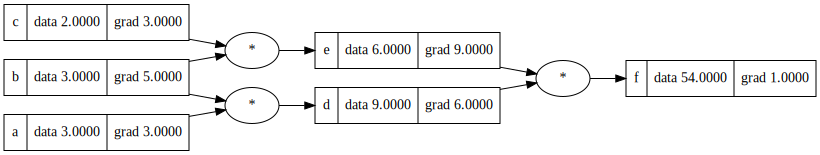

In [43]:
a = Value(3, label='a')
b = Value(3, label='b')
c = Value(2, label='c')

d = a*b; d.label='d'
e = b*c; e.label='e'

f = d*e; f.label='f'
f.grad = 1

draw(f)

O problema aqui é que estamos calculando a derivada na medida em que construímos o gráfico, da esquerda para a direita ("forward pass"). Ao invés disso, precisamos calcular as derivadas da direita para a esquerda e ir multiplicando os termos pela regra da cadeira ("backward pass").

Para isso, vamos ter que modificar nossa classe uma última vez. Ao invés de ir atualizando o gradiente toda vez que uma operação, como `+` ou `*`, é realizada, vamos incluir uma função dentro de cada operação que especifica como o gradiente deve ser atualizado, mas essa função só é chamada ao final da construção do grafo, via uma função `backward_prop()`, que percorre o gráfico da direita para a esquerda chamando a função `_update_grad()` interna a cada operação e atualizando o gradiente de maneira correspondente.

In [44]:
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0
        self._update_grad = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __add__(self, other):  # self + other
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _update_grad():
            self.grad += out.grad
            other.grad += out.grad
        out._update_grad = _update_grad

        return out

    def __mul__(self, other): # self * other
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _update_grad():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._update_grad = _update_grad

        return out

    def __pow__(self, other):  # self ** other
        assert isinstance(other, (int, float)), "Only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _update_grad():
            self.grad += (other * self.data**(other-1)) * out.grad
        out._update_grad = _update_grad

        return out

    def relu(self):
        out = Value(0 if self.data < 0 else self.data, (self,), 'ReLU')

        def _update_grad():
            self.grad += (out.data > 0) * out.grad
        out._update_grad = _update_grad

        return out

    def __neg__(self): # -self
        return self * -1

    def __radd__(self, other): # other + self
        return self + other

    def __sub__(self, other): # self - other
        return self + (-other)

    def __rsub__(self, other): # other - self
        return other + (-self)

    def __rmul__(self, other): # other * self
        return self * other

    def __truediv__(self, other): # self / other
        return self * other**-1

    def __rtruediv__(self, other): # other / self
        return other * self**-1

    def __repr__(self):
        return f"Value(data={self.data}, grad={self.grad})"

    def backward_prop(self):
        # Ordene topologicamente cada elemento do grafo
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        # Em cada operação, aplique a função _update_grad() para acumular o gradiente via regra da cadeia
        self.grad = 1
        for v in reversed(topo):
            v._update_grad()

Agora, vamos voltar ao exemplo anterior. Primeiro, construímos o grafo. Note que os gradientes estão todos inicializados com zero.

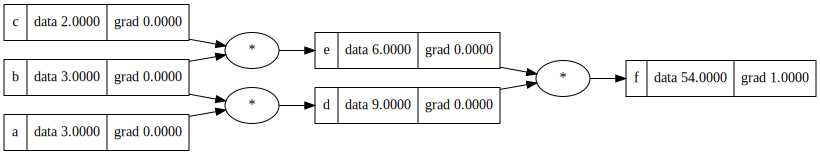

In [45]:
a = Value(3, label='a')
b = Value(3, label='b')
c = Value(2, label='c')

d = a*b; d.label='d'
e = b*c; e.label='e'

f = d*e; f.label='f'
f.grad = 1

draw(f)

E rodando `backward_prop()` percorremos todo o grafo acumulando as derivadas.

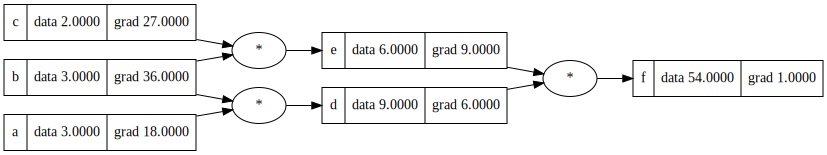

In [46]:
f.backward_prop()
draw(f)

Agora conseguimos calcular automaticamente derivadas! Vamos voltar ao nosso exemplo original de derivada parcial e ver quão longe já chegamos.

In [47]:
# Derivada parcial
def f(a, b, c, d):
    return (a*b+c)*d

h = 0.0000000001
a = 2
b = -3
c = 10
d = -2

print(f" Derivada em a: {(f(a+h, b, c, d)-f(a, b, c, d))/h}")
print(f" Derivada em b: {(f(a, b+h, c, d)-f(a, b, c, d))/h}")
print(f" Derivada em c: {(f(a, b, c+h, d)-f(a, b, c, d))/h}")
print(f" Derivada em d: {(f(a, b, c, d+h)-f(a, b, c, d))/h}")

 Derivada em a: 6.000000496442226
 Derivada em b: -4.000000330961484
 Derivada em c: -2.000000165480742
 Derivada em d: 4.000000330961484


In [48]:
a = Value(2, label='a')
b = Value(-3, label='b')
c = Value(10, label='c')
d = Value(-2, label='d')

f = (a*b+c)*d
f.backward_prop()

print(f" Derivada em a: {a.grad}")
print(f" Derivada em b: {b.grad}")
print(f" Derivada em c: {c.grad}")
print(f" Derivada em d: {d.grad}")

 Derivada em a: 6
 Derivada em b: -4
 Derivada em c: -2
 Derivada em d: 4


## Neurônios, camadas e redes

Vamos aplicar essa ferramenta num caso mais parecido com o que nos interessa: um neurônio.

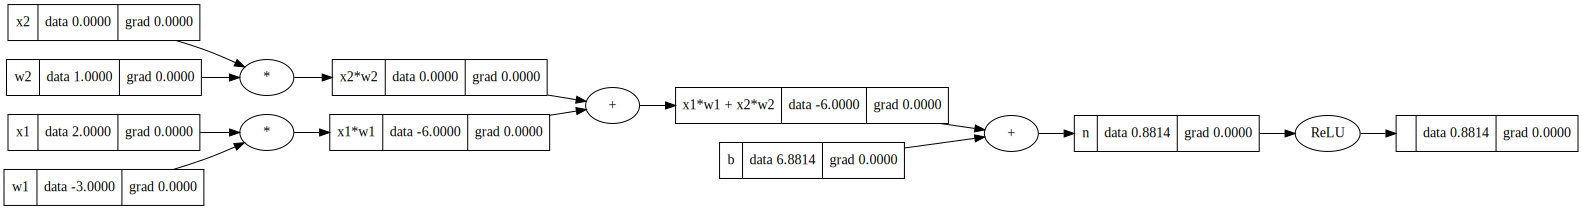

In [49]:
# Inputs: x1, x2
x1 = Value(2, label='x1')
x2 = Value(0, label='x2')

# Weights: w1, w2
w1 = Value(-3, label='w1')
w2 = Value(1, label='w2')

# Bias
b = Value(6.8813735870195432, label='b')

# Neuron
x1w1 = x1 * w1; x1w1.label='x1*w1'
x2w2 = x2 * w2; x2w2.label='x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label='n'
o = n.relu()

draw(o)

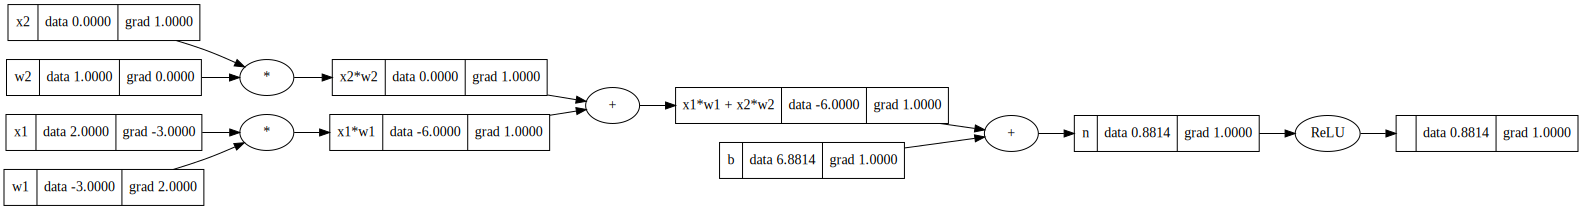

In [50]:
o.backward_prop()
draw(o)

Agora, já temos os ingredientes para rodar descida de gradiente nesse neurônio!

Antes disso, vamos já montar as estruturas necessárias para criar uma rede inteira. Aqui, é suficiente pensar numa camada da rede como uma lista de neurônios, e uma rede em si como uma lista de camadas. Cada um desses objetos vai ser uma classe. Primeiro, criamos uma classe `Module` com elementos que todas as outras classes vão herdar: uma função para zerar os gradientes, `zero_grad()` e outra para guardar os parâmetros, `parameters()`.

In [51]:
class Module:

    def zero_grad(self):
        for p in self.parameters():
            p.grad = 0

    def parameters(self):
        return []

A classe `Neuron` encapsula o que já fizemos antes: é uma coleção de pesos `w` e `b`, junto de uma função de ativação. Note que a função `__call__` é outra função com sentido especial: ela especifica o que acontece quando aplicamos o objeto como uma função.

In [52]:
class Neuron(Module):

    def __init__(self, nin, nonlin=True):
        # Inicialização aleatória
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(0)
        self.nonlin = nonlin

    def __call__(self, x):
        # Ativação = g(w * x + b)
        act = sum((wi*xi for wi,xi in zip(self.w, x)), self.b)
        return act.relu() if self.nonlin else act

    def parameters(self):
        return self.w + [self.b]

    def __repr__(self):
        return f"{'ReLU' if self.nonlin else 'Linear'}Neuron({len(self.w)})"

In [53]:
# Neurônio
x = [2, 3]
n = Neuron(2) # 2 inputs
n(x)  # g(w1x1+w2x2+b)

Value(data=0, grad=0)

Uma camada é apenas uma lista de neurônios.

In [54]:
class Layer(Module):
    
    def __init__(self, nin, nout, **kwargs):
        self.neurons = [Neuron(nin, **kwargs) for _ in range(nout)]

    def __call__(self, x):
        out = [n(x) for n in self.neurons]
        return out[0] if len(out) == 1 else out

    def parameters(self):
        return [p for n in self.neurons for p in n.parameters()]

    def __repr__(self):
        return f"Layer of [{', '.join(str(n) for n in self.neurons)}]"

In [55]:
x = [2, 3]
n = Layer(2, 4) # Camda com 4 neurônios, cada um recebendo 2 inputs
n(x)

[Value(data=0, grad=0),
 Value(data=0, grad=0),
 Value(data=0, grad=0),
 Value(data=0, grad=0)]

Finalmente, uma rede neural é uma lista de camadas.

In [56]:
class NN(Module):

    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1], nonlin=i!=len(nouts)-1) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

    def __repr__(self):
        return f"NN of [{', '.join(str(layer) for layer in self.layers)}]"

In [57]:
x = [2, 3, -1]
n = NN(3, [3, 3, 3, 1]) # rede com 3 inputs, e camadas de 3 neurônios, 3 neurônios, 3 neurônios e 1 último neurônio
n(x)

Value(data=-0.3226312874175273, grad=0)

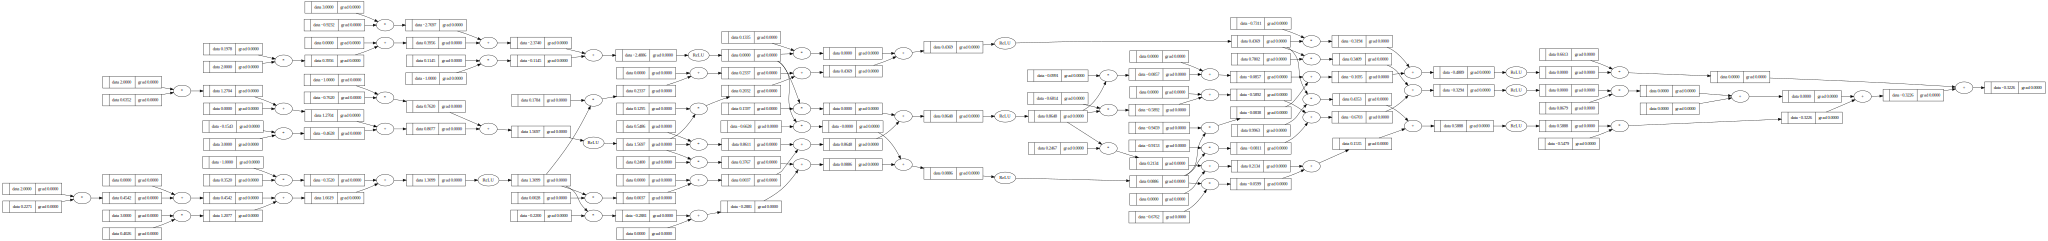

In [58]:
draw(n(x))

É um objeto bem complicado de entender, mas ainda assim não é difícil obter as derivadas todas em relação aos pesos! 

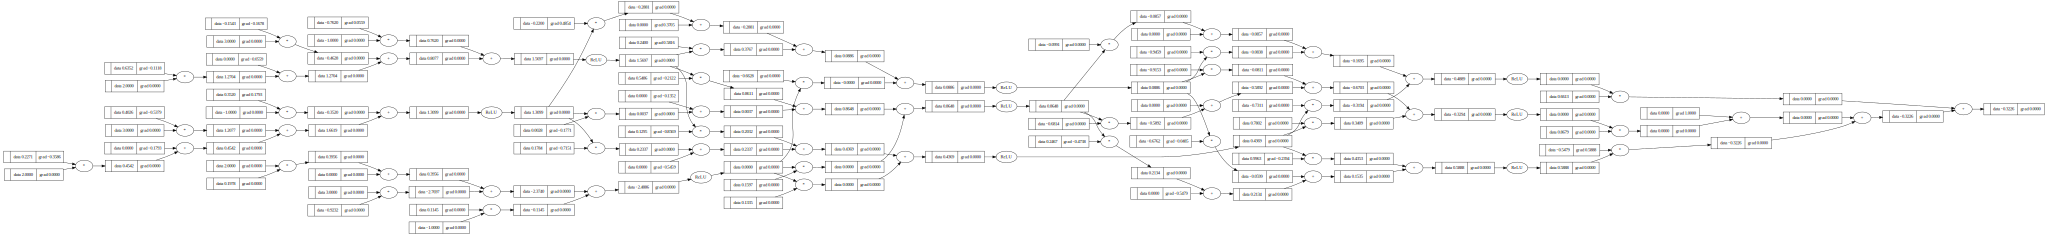

In [59]:
n(x).backward_prop()
draw(n(x))

## Exemplo: otimizando uma rede neural

In [60]:
random.seed(1)
x = [2, 3, -1]
n = NN(3, [3, 3, 3, 1])
n(x)

Value(data=0.0, grad=0)

In [61]:
xs = [
    [2, 3, -1],
    [3, -1, 0.5],
    [0.5, 1, 1],
    [1, 1, -1]
]
ys = [1, -1, -1, 1]

In [62]:
ypred = [n(x) for x in xs]
ypred

[Value(data=0.0, grad=0),
 Value(data=0.0, grad=0),
 Value(data=-0.037831584502997125, grad=0),
 Value(data=0.0, grad=0)]

In [63]:
loss = sum((yout-ygt)**2 for ygt, yout in zip(ys, ypred))
loss

Value(data=3.925768059780013, grad=0)

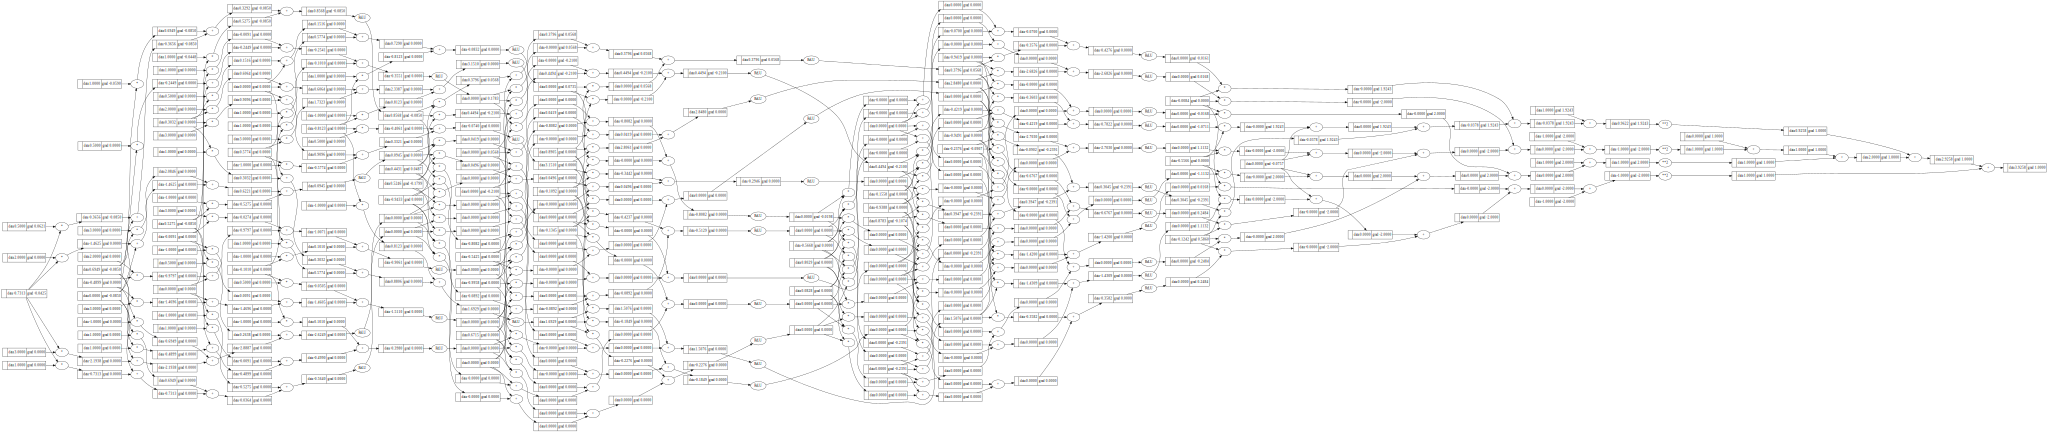

In [64]:
loss.backward_prop()
draw(loss)

Vamos dar um passo na direção oposta ao gradiente e ver o que acontece com os parâmetros. O primeiro peso do primeiro neurônio da primeira camada tem o seguinte valor e gradiente:

In [65]:
print(n.layers[0].neurons[0].w[0].data)
print(n.layers[0].neurons[0].w[0].grad)

-0.7312715117751976
-0.042485019612801475


Agora, damos um passo na direção oposta ao gradiente com taxa de aprendizado 0.01:

In [66]:
for p in n.parameters():
    p.data -= 0.01 * p.grad

Repare que o valor do parâmetro mudou:

In [67]:
print(n.layers[0].neurons[0].w[0].data)
print(n.layers[0].neurons[0].w[0].grad)

-0.7308466615790695
-0.042485019612801475


Será que isso ajudou a minimizar a perda?

In [68]:
ypred = [n(x) for x in xs]
loss = sum((yout-ygt)**2 for ygt, yout in zip(ys, ypred))
loss

Value(data=3.919266474159568, grad=0)

Parece que ajudou. E se fizéssemos vários passos de uma vez?

In [69]:
for k in range(30):
    
    # Forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout-ygt)**2 for ygt, yout in zip(ys, ypred))
    
    # Backward pass
    for p in n.parameters():
        p.grad = 0.0
    loss.backward_prop()
    
    # Update
    for p in n.parameters():
        p.data -= 0.05 * p.grad
    
    print(k, loss.data)

0 3.919266474159568
1 3.8666485872062486
2 3.7816880361135925
3 3.646252970487985
4 3.436313987737009
5 3.1271214606887394
6 2.7454605451012837
7 2.373882848238691
8 1.891396201379884
9 1.631513497697374
10 1.2805463056955049
11 1.0315325657933865
12 0.8324207766750455
13 0.6898992064107249
14 0.6108333564489764
15 0.4765896213836914
16 0.37842482974938196
17 0.30189253405145844
18 0.2422689794697424
19 0.19422232586892169
20 0.15681767120133752
21 0.12671099440048894
22 0.10292191373005927
23 0.08428907076579455
24 0.06892338336479703
25 0.05702939289466246
26 0.047357312517058665
27 0.039411586571761664
28 0.033102163713181865
29 0.02803941572105273


Parece que estamos chegando num bom lugar. As previsões são:

In [70]:
ypred

[Value(data=0.9518367471346557, grad=-0.09632650573068857),
 Value(data=-0.8742160482112454, grad=0.25156790357750913),
 Value(data=-1.0870540943340106, grad=-0.17410818866802114),
 Value(data=0.9518367471346557, grad=-0.09632650573068857)]

E de fato batem com `ys = [1, -1, -1, 1]`!

## Aplicação: dataset `moons`

Finalmente, vamos aplicar a nossa ferramenta para otimizar uma rede neural num dataset não-trivial. Vamos baixá-lo diretamente do `sklearn`.

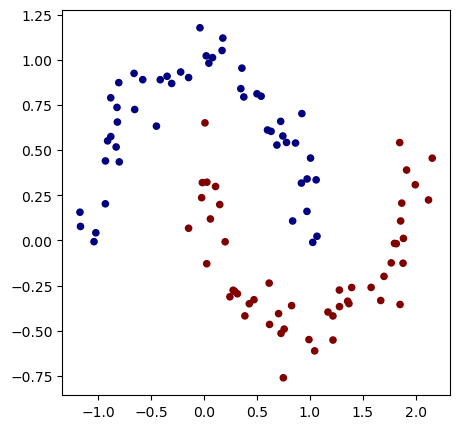

In [71]:
np.random.seed(1)
random.seed(1)

from sklearn.datasets import make_moons, make_blobs
X, y = make_moons(n_samples=100, noise=0.1)

y = y*2 - 1 # y is -1 or 1
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')

Usaremos uma rede neural com duas camadas escondidas de 16 neurônios cada, totalizando 337 parâmetros.

In [72]:
model = NN(2, [16, 16, 1]) # 2-layer neural network
print(model)
print("\nNumber of parameters", len(model.parameters()))

NN of [Layer of [ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2)], Layer of [ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16)], Layer of [LinearNeuron(16)]]

Number of parameters 337


Vamos definir a perda para ser utilizada pela rede neural. Note que a perda que está sendo usada é a de SVM com uma regularização via o parâmetro alpha.

In [73]:
def loss(batch_size=None):
    
    # Por default, usamos todos os dados na perda, mas podemos usar só um batch 
    if batch_size is None:
        Xb, yb = X, y
    else:
        ri = np.random.permutation(X.shape[0])[:batch_size]
        Xb, yb = X[ri], y[ri]
    inputs = [list(map(Value, xrow)) for xrow in Xb]
    
    # Forward pass para obter as previsões
    scores = list(map(model, inputs))
    
    # Perda hinge de SVM
    losses = [(1 + -yi*scorei).relu() for yi, scorei in zip(yb, scores)]
    data_loss = sum(losses) * (1.0 / len(losses))

    # Termo de regularização para a perda
    alpha = 1e-4
    reg_loss = alpha * sum((p*p for p in model.parameters()))
    total_loss = data_loss + reg_loss
    
    # Retorne a acurácia para obter métricas de diagnósticos
    accuracy = [(yi > 0) == (scorei.data > 0) for yi, scorei in zip(yb, scores)]
    return total_loss, sum(accuracy) / len(accuracy)

total_loss, acc = loss()
print(total_loss, acc)

Value(data=0.6195071936644958, grad=0) 0.76


Finalmente, rode 100 iterações de descida de gradiente com um learning rate com decaimento

In [74]:
for k in range(100):
    
    # Forward pass
    total_loss, acc = loss()
    
    # Backward pass
    model.zero_grad()
    total_loss.backward_prop()
    
    # Update
    learning_rate = 1.0 - 0.9*k/100
    for p in model.parameters():
        p.data -= learning_rate * p.grad
    
    if k % 1 == 0:
        print(f"step {k} loss {total_loss.data}, accuracy {acc*100}%")

step 0 loss 0.6195071936644958, accuracy 76.0%
step 1 loss 0.5528191443450594, accuracy 79.0%
step 2 loss 0.35368878171951396, accuracy 84.0%
step 3 loss 0.3024571277559429, accuracy 87.0%
step 4 loss 0.2483273764260679, accuracy 87.0%
step 5 loss 0.19587362870477665, accuracy 88.0%
step 6 loss 0.26460586015134674, accuracy 96.0%
step 7 loss 0.37053114027633505, accuracy 87.0%
step 8 loss 0.2896992350412708, accuracy 87.0%
step 9 loss 0.16666059179383513, accuracy 92.0%
step 10 loss 0.16318107610605054, accuracy 94.0%
step 11 loss 0.19418010587856294, accuracy 92.0%
step 12 loss 0.2066664037328464, accuracy 91.0%
step 13 loss 0.13598454546532374, accuracy 95.0%
step 14 loss 0.07745227695811409, accuracy 97.0%
step 15 loss 0.07851779746397003, accuracy 99.0%
step 16 loss 0.08916529295158607, accuracy 98.0%
step 17 loss 0.160882526777689, accuracy 94.0%
step 18 loss 0.07569935361357284, accuracy 97.0%
step 19 loss 0.05918533602569772, accuracy 98.0%
step 20 loss 0.053361255527454715, acc

Encontramos uma acurácia perfeita de treino. Podemos inclusive visualizar a fronteira de decisão.

(-1.7609251085622153, 1.9890748914377847)

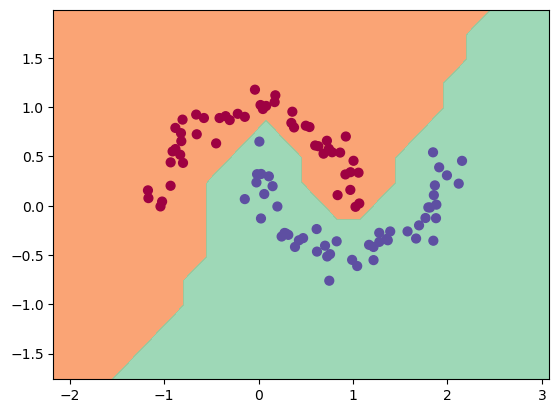

In [75]:
h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
inputs = [list(map(Value, xrow)) for xrow in Xmesh]
scores = list(map(model, inputs))
Z = np.array([s.data > 0 for s in scores])
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

É claro que todos os resultados acima são num conjunto de treino, onde é fácil overfit. Ainda assim, esse notebook deixa claro como funcionam as grandes bibliotecas de deep learning e a razão de backpropagation ser um algoritmo tão interessante. Na prática, muita otimização é feita para deixar as bibliotecas rápidas e paralelizáveis, além de tomar cuidado com estabilidade numérica e outras considerações estatísticas para acelerar a convergência do treino.

## O caso vetorial

Acima, cada Value guarda um número apenas. Isso eventualmente se torna bastante ineficiente quando temos que trabalhar com vetores e matrizes, dado que muito dos cálculos necessários são facilmente paralelizáveis (por exemplo, ao invés de calcular $\mathbf{v}^T\mathbf{v} = \sum_{i=1}^n v_i^2$ olhando primeiro para $v_1^2$, depois somando $v_2^2$ ao resultado, depois somando $v_3^2$ ao resultado, etc., o computador pode usar vários núcleos do processador para cada um calcular $v_i^2$ em paralelo, e aí basta somar o resultado).

Os pacotes que usam diferenciação automática para otimizar redes neurais, como o PyTorch, trabalham no nível de tensores (i.e., vetores, matrizes e análogos de dimensões maiores). Se você tiver inclinações computacionais, um exercício interessante é repensar como o código acima pode ser reescrito para lidar com vetores ao invés de números.

Uma possível solução está aqui: https://x0axz.com/blog/autograd.html